<a href="https://colab.research.google.com/github/colleym-cloud/AI-project/blob/main/sentiment-analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## importing the data

In [19]:
# Import Data
df = pd.read_csv('adidasdata.csv')



In [18]:
df.shape

(1106, 10)

# sentiment analysis with vader

In [14]:
sie = SentimentIntensityAnalyzer()

In [15]:
sie.polarity_scores('I love this shoe')

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.6369}

In [16]:
sie.polarity_scores("I hate this shoe, i cant walk in it")

{'neg': 0.381, 'neu': 0.619, 'pos': 0.0, 'compound': -0.5719}

In [20]:
df['Reviews'] = df['Reviews'].astype(str)

In [22]:
df['PolarityScores'] = [sie.polarity_scores(x)['compound'] for x in df['Reviews']]

In [23]:
df.head()

,Unnamed: 0,Title,Price,ColoursAvailable,ReviewTopic,Reviews,UserID,Date,VerifiedPurchaser,IncentivizedReview,PolarityScores
0,0,Samba OG Shoes,100,6,Nice quality shoes,They match practically with any outfit that I...,abdubs35,"September 13, 2023",False,False,0.0000
1,1,Samba OG Shoes,100,6,Nice shoes,"Very nice shoes , just not as green as the pic...",THEMAN,"September 13, 2023",False,True,0.4754
2,2,Samba OG Shoes,100,6,Buy the shoes!,"Bang on trend, comfy and cool. Would recommend...",Huggsy,"September 12, 2023",True,True,0.5859
3,3,Samba OG Shoes,100,6,ALL GOODS SOLID! WORTH THE PRICE!,THAT WAS DOPE! medyo mahaba lng ng very little...,TOYOTABOY,"September 12, 2023",False,False,-0.4997
4,4,Samba OG Shoes,100,6,Never out of style,Love how light on your feet they are and comfo...,SangeBo,"September 12, 2023",False,False,0.8176


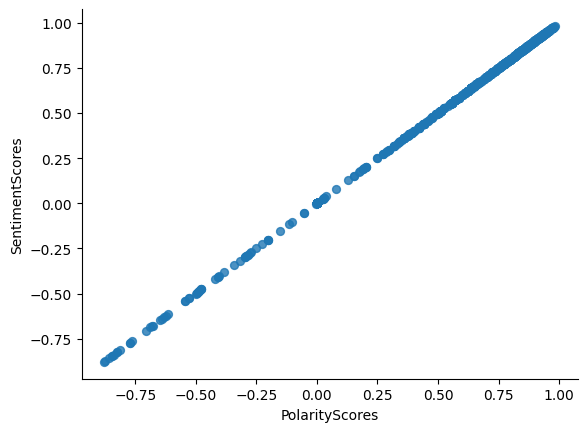

In [39]:
# @title PolarityScores vs SentimentScores

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='PolarityScores', y='SentimentScores', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# classification


In [27]:
df['SentimentScores'] = df['Reviews'].apply(lambda x: sie.polarity_scores(x)['compound'])
X = df[['SentimentScores']].values  # Feature: Sentiment scores
y = df['ReviewTopic'].values  # Label: Review topic

In [33]:
positive_threshold = 0.2
negative_threshold = -0.2

# Function to classify sentiment based on polarity score
def classify_sentiment(score):
    if score > positive_threshold:
        return 'Positive'
    elif score < negative_threshold:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the classification function to polarity scores
df['Sentiment'] = df['PolarityScores'].apply(classify_sentiment)

In [35]:
# Train-test split
X = df[['PolarityScores']].values  # Feature: Polarity scores
y = df['Sentiment'].values  # Target: Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)


LogisticRegression()

In [36]:
# Predictions
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [37]:
# Evaluate performance
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Train Accuracy: 0.9841628959276018
Test Accuracy: 0.990990990990991
